In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

In [11]:
from tensorflow.keras.datasets import mnist

# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train.astype("float32") / 255.0

# Check shape
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28)


In [3]:
from tensorflow import keras
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,609 (1.51 MB)

 Trainable params: 396,609 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
latent_dim = 100

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(7 * 7 * 128),
        layers.Reshape((7, 7, 128)),

        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),

        layers.Conv2D(1, kernel_size=7, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │         3,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,030,017 (3.93 MB)

 Trainable params: 1,030,017 (3.93 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)  # it is use to update thee weight
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [16]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images.numpy()

        plt.figure(figsize=(5, 5))
        for i in range(self.num_img):
            plt.subplot(3, 4, i + 1)
            plt.imshow(generated_images[i].squeeze(), cmap="gray")
            plt.axis("off")
        plt.show()


In [17]:
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - d_loss: 0.5009 - g_loss: 1.4731

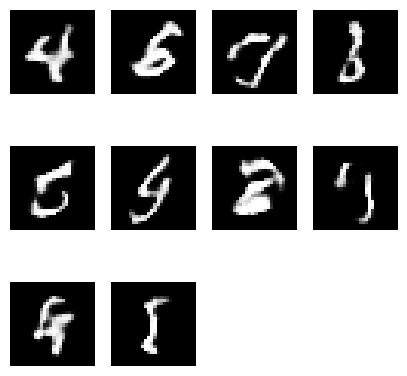

469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - d_loss: 0.5008 - g_loss: 1.4731
Epoch 2/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 0.4850 - g_loss: 1.5123

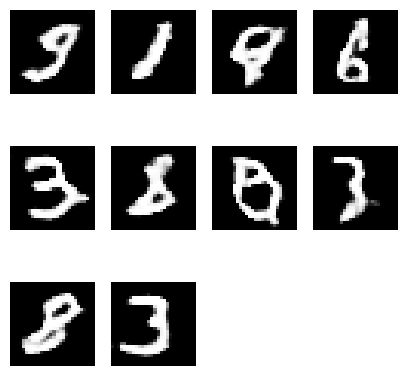

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.4850 - g_loss: 1.5124
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.4785 - g_loss: 1.5213

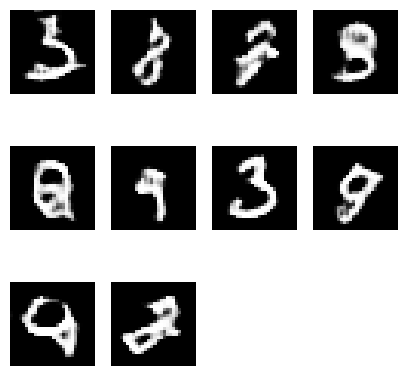

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.4785 - g_loss: 1.5212
Epoch 4/50
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.4819 - g_loss: 1.3988

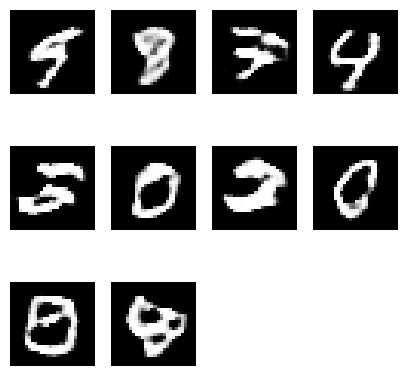

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4819 - g_loss: 1.3988
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.4897 - g_loss: 1.4540

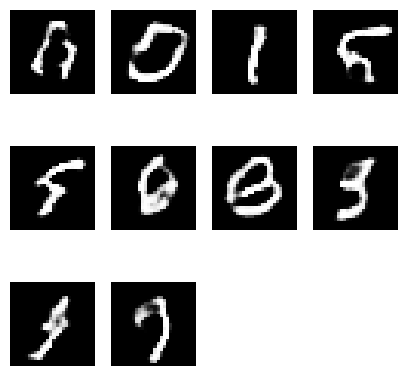

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4897 - g_loss: 1.4542
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.4881 - g_loss: 1.5578

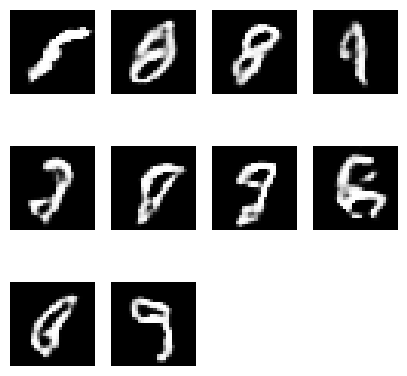

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.4881 - g_loss: 1.5577
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.4802 - g_loss: 1.4125

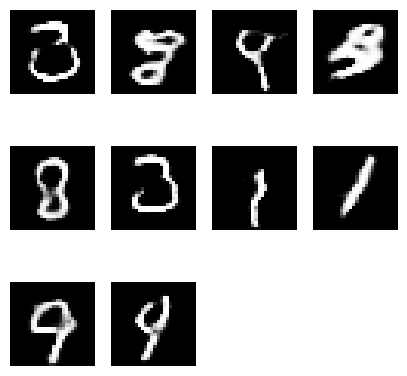

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4802 - g_loss: 1.4125
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4755 - g_loss: 1.3878

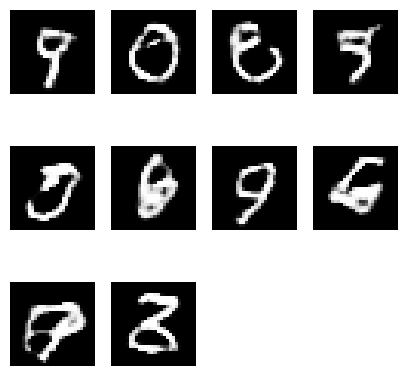

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4755 - g_loss: 1.3878
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4740 - g_loss: 1.4375

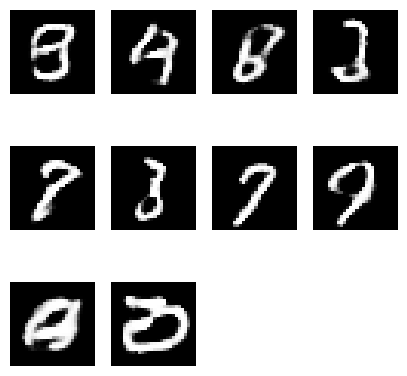

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4741 - g_loss: 1.4376
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4720 - g_loss: 1.4608

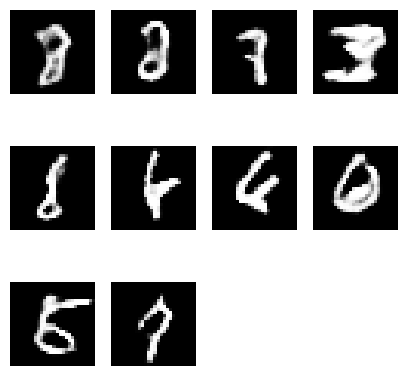

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4720 - g_loss: 1.4608
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4746 - g_loss: 1.4573

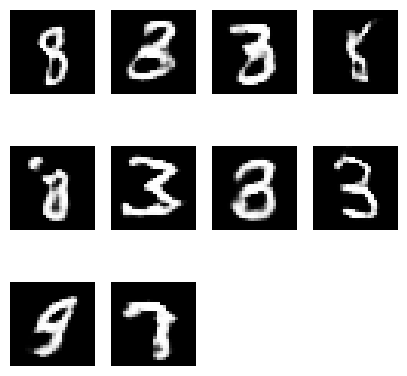

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4746 - g_loss: 1.4572
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4749 - g_loss: 1.4227

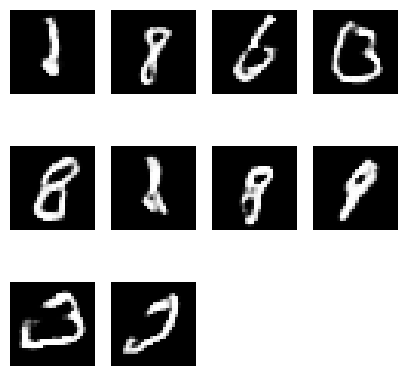

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4749 - g_loss: 1.4227
Epoch 13/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4744 - g_loss: 1.4401

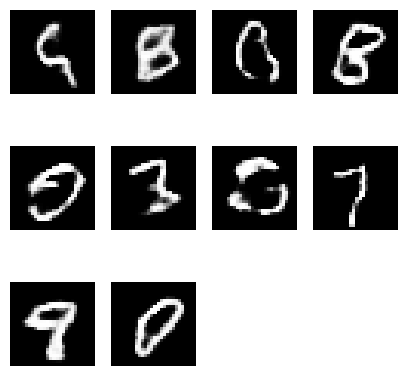

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4744 - g_loss: 1.4401
Epoch 14/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4750 - g_loss: 1.4438

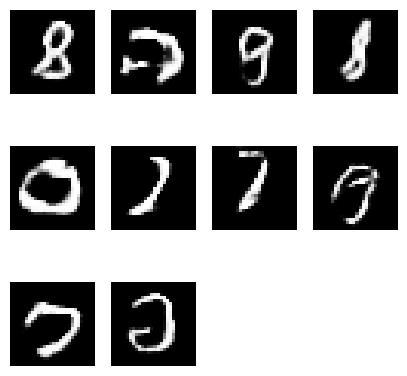

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4750 - g_loss: 1.4437
Epoch 15/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4812 - g_loss: 1.4218

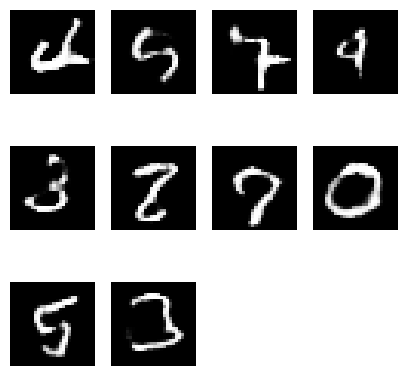

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4812 - g_loss: 1.4218
Epoch 16/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4837 - g_loss: 1.5634

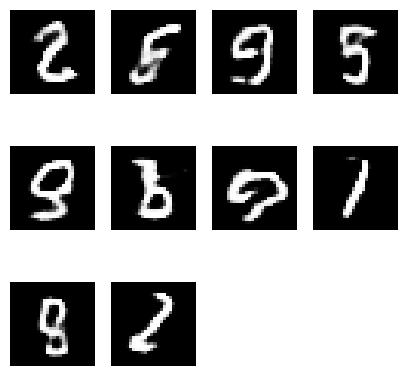

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4837 - g_loss: 1.5636
Epoch 17/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4785 - g_loss: 1.7885

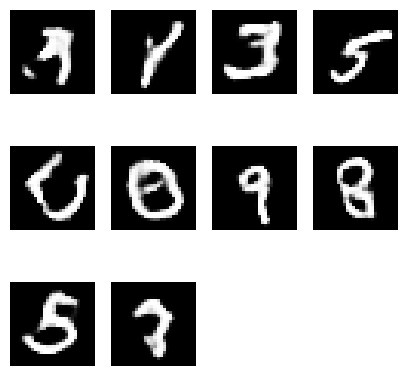

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4785 - g_loss: 1.7883
Epoch 18/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4702 - g_loss: 1.4905

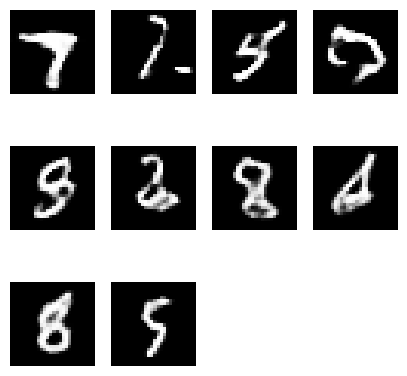

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4702 - g_loss: 1.4904
Epoch 19/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4790 - g_loss: 1.4086

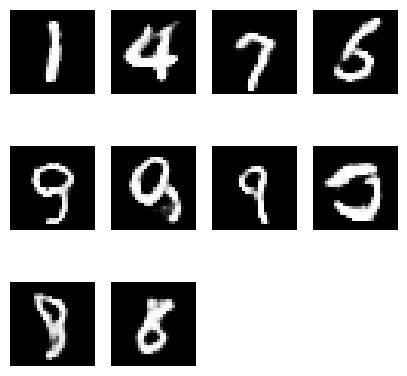

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4790 - g_loss: 1.4086
Epoch 20/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4818 - g_loss: 1.4524

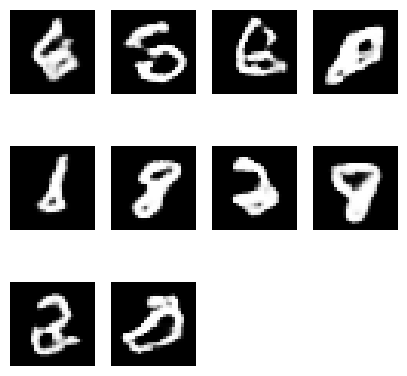

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4819 - g_loss: 1.4523
Epoch 21/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4807 - g_loss: 1.4136

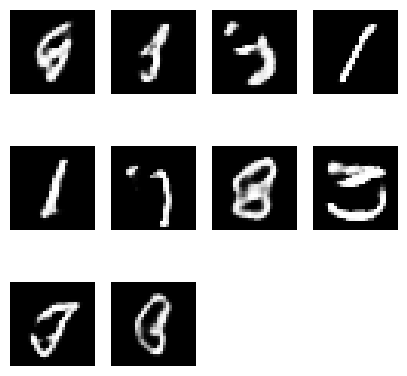

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4807 - g_loss: 1.4135
Epoch 22/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4822 - g_loss: 1.4222

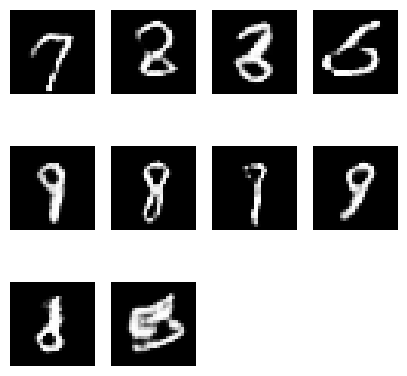

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4822 - g_loss: 1.4223
Epoch 23/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4889 - g_loss: 1.8253

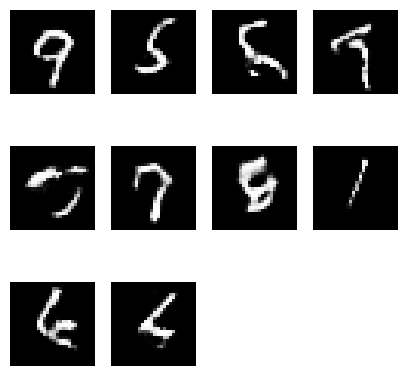

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4889 - g_loss: 1.8253
Epoch 24/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4661 - g_loss: 1.6235

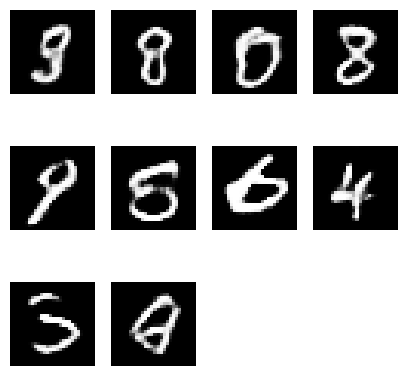

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4661 - g_loss: 1.6233
Epoch 25/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4834 - g_loss: 1.4498

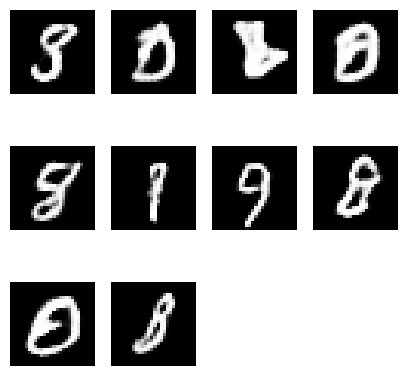

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4834 - g_loss: 1.4498
Epoch 26/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4843 - g_loss: 1.3997

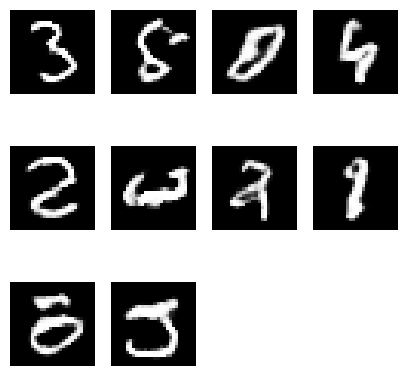

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4843 - g_loss: 1.3997
Epoch 27/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4841 - g_loss: 1.4120

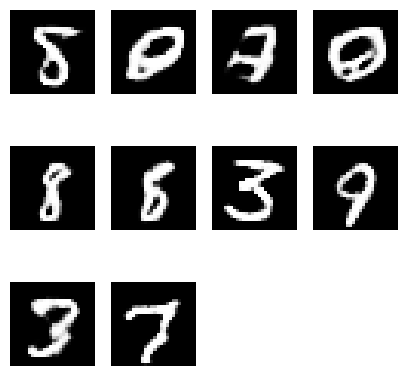

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4841 - g_loss: 1.4121
Epoch 28/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4857 - g_loss: 1.6903

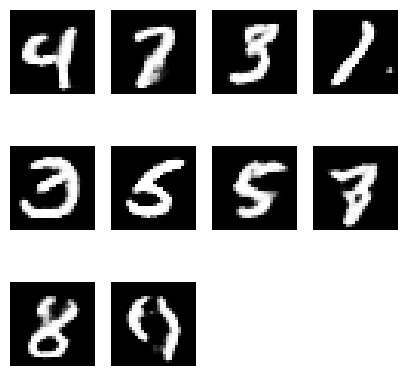

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4857 - g_loss: 1.6904
Epoch 29/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4746 - g_loss: 1.5990

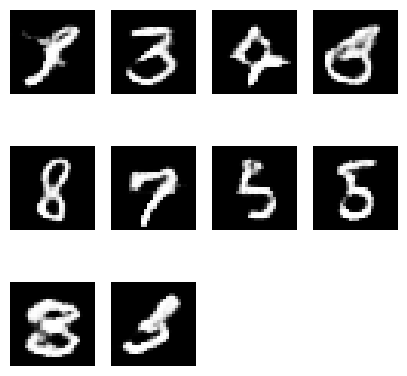

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4746 - g_loss: 1.5988
Epoch 30/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4778 - g_loss: 1.4298

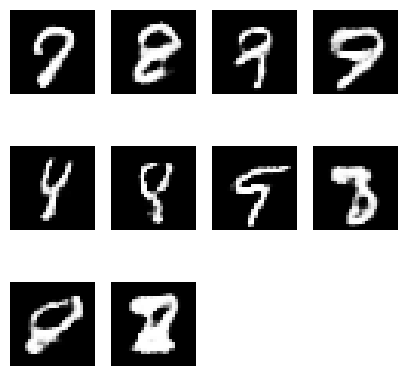

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4779 - g_loss: 1.4298
Epoch 31/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4801 - g_loss: 1.3960

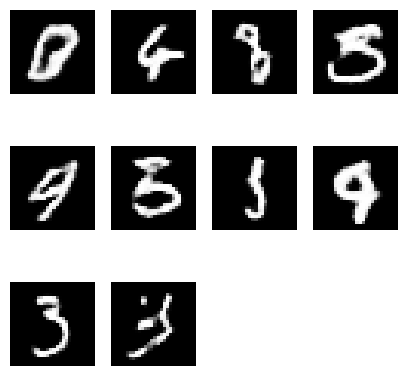

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4801 - g_loss: 1.3960
Epoch 32/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4851 - g_loss: 1.4252

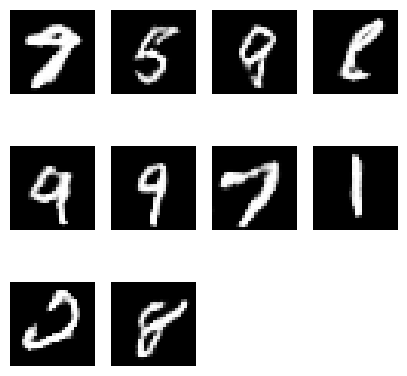

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4851 - g_loss: 1.4252
Epoch 33/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4824 - g_loss: 1.4248

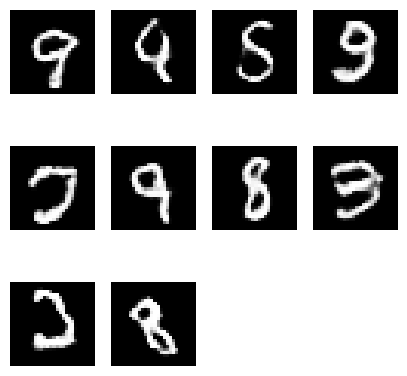

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4824 - g_loss: 1.4248
Epoch 34/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4914 - g_loss: 1.4327

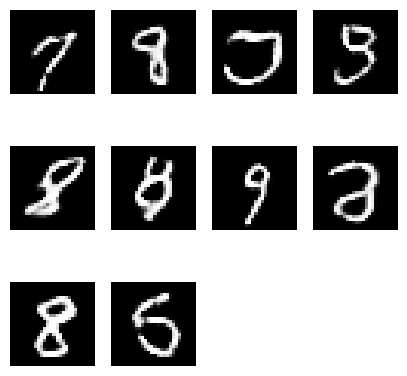

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4914 - g_loss: 1.4327
Epoch 35/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4928 - g_loss: 1.5654

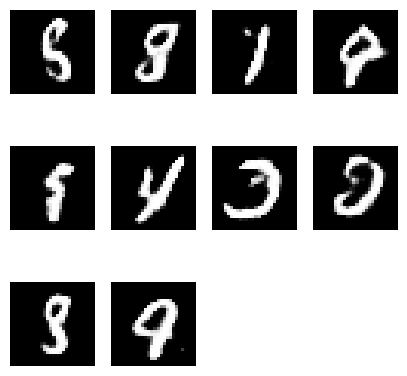

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4928 - g_loss: 1.5657
Epoch 36/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4899 - g_loss: 1.6674

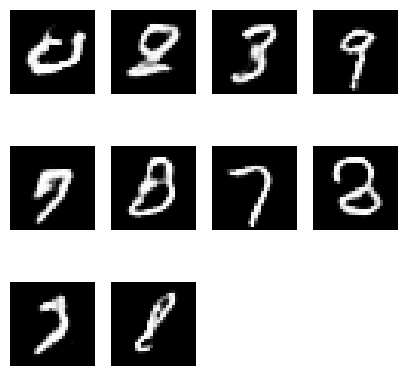

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4899 - g_loss: 1.6672
Epoch 37/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4837 - g_loss: 1.5120

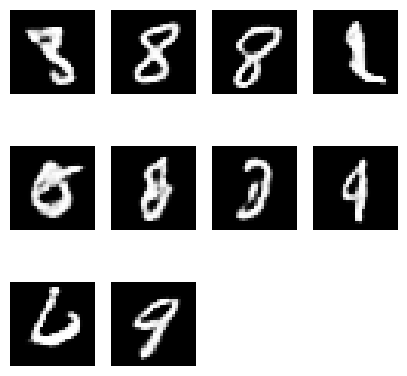

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4837 - g_loss: 1.5120
Epoch 38/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4859 - g_loss: 1.4143

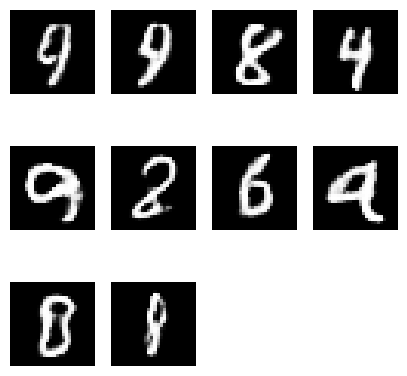

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4859 - g_loss: 1.4143
Epoch 39/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4876 - g_loss: 1.3766

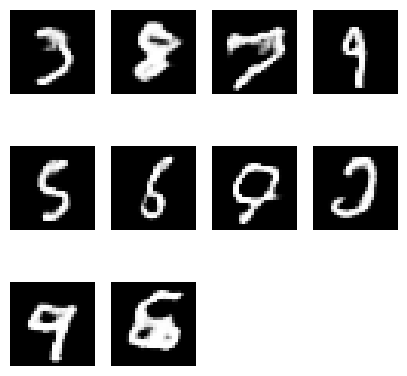

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4876 - g_loss: 1.3766
Epoch 40/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4922 - g_loss: 1.3889

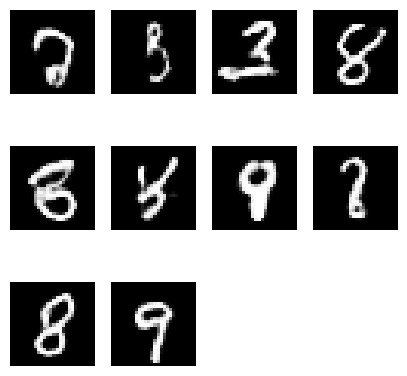

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4922 - g_loss: 1.3890
Epoch 41/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4905 - g_loss: 1.4420

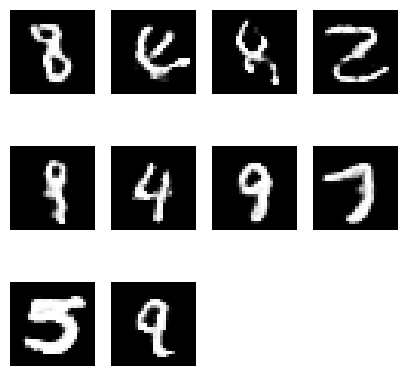

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4905 - g_loss: 1.4419
Epoch 42/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4882 - g_loss: 1.4300

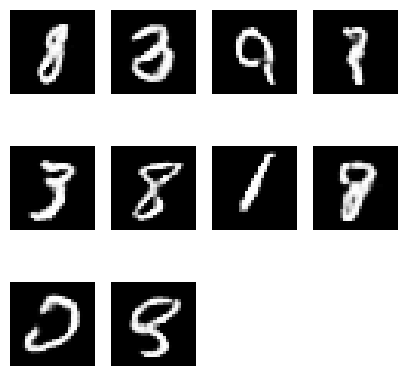

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4882 - g_loss: 1.4300
Epoch 43/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4938 - g_loss: 1.4046

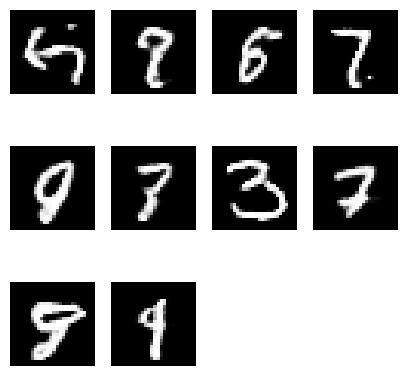

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4938 - g_loss: 1.4045
Epoch 44/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4952 - g_loss: 1.3868

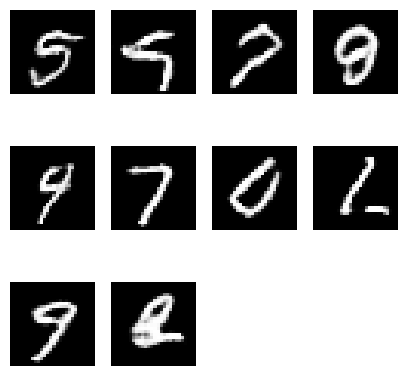

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.4952 - g_loss: 1.3867
Epoch 45/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4982 - g_loss: 1.4135

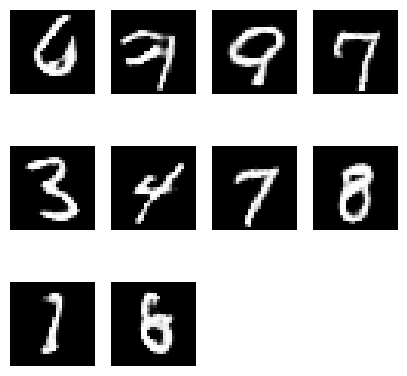

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4982 - g_loss: 1.4135
Epoch 46/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4995 - g_loss: 1.4097

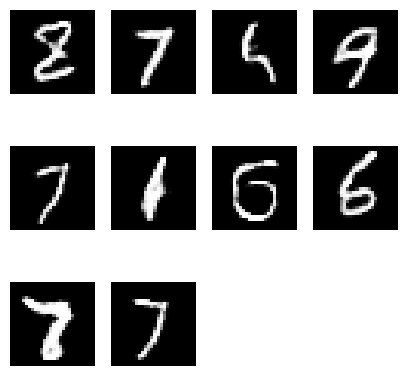

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - d_loss: 0.4995 - g_loss: 1.4097
Epoch 47/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4988 - g_loss: 1.3989

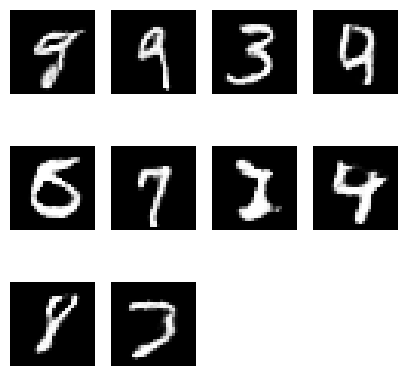

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4988 - g_loss: 1.3988
Epoch 48/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.5061 - g_loss: 1.3841

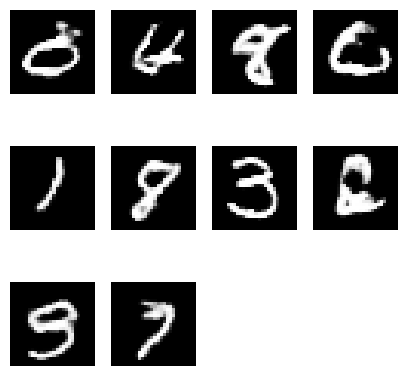

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - d_loss: 0.5061 - g_loss: 1.3840
Epoch 49/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4993 - g_loss: 1.3847

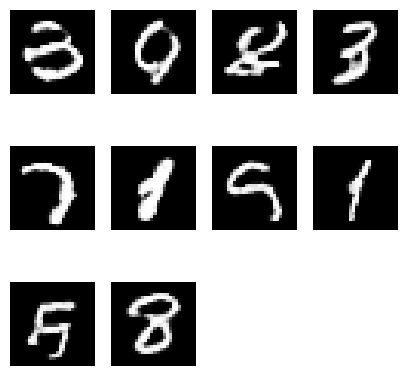

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4993 - g_loss: 1.3847
Epoch 50/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.4983 - g_loss: 1.3571

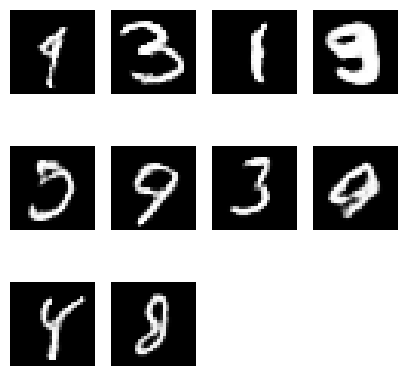

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.4983 - g_loss: 1.3571


In [18]:
epochs = 50  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)